In [2]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats
import math
import seaborn as sns
%matplotlib inline
sns.set(style='whitegrid', color_codes = True)




# Import Sheet as csv 

In [3]:
ps = pd.read_csv('patch_seq_log_mouse.csv')




# Format sheet 

In [4]:
ps = ps[["Date", "User", "File", "Post patch?", "Notes", "Picogreen", "Conc.", ">400", "Ratio", "SM_QC_PF", "Bad dates"]]
#ps.dropna(subset = ["SM_QC_PF", "Post patch?"], inplace = True)
ps.dropna(subset = ["Notes", "Picogreen"], inplace = True)
ps["User"] = ps["User"].astype("category")
ps["SM_QC_PF"] = ps["SM_QC_PF"].astype("category")
ps["Post patch?"] = ps["Post patch?"].astype("category")
ps["Picogreen"] = pd.to_numeric(ps["Picogreen"].str.replace(' ',''), errors='force')
ps["Conc."] = pd.to_numeric(ps["Conc."].str.replace(' ',''), errors ='force')
ps[">400"] = pd.to_numeric(ps[">400"].str.replace(' ',''), errors ='force')
ps["Date"] = pd.to_datetime(ps["Date"], format = '%y%m%d')
ps = ps[ps["SM_QC_PF"] != "cnt"]
ps = ps[ps["Bad dates"] != "x"]
ps

,Date,User,File,Post patch?,Notes,Picogreen,Conc.,>400,Ratio,SM_QC_PF,Bad dates
5005,2017-04-20,P2,Vip-IRES-Cre;Ai14-313534.04.01.02,No-Seal,approached angle same as tissue angle,1012.0,978.8,558.000,0.57,pass,NaN
5006,2017-04-20,P2,Vip-IRES-Cre;Ai14-313534.04.01.03,No-Seal,approach angle same as slice angle,940.0,1166.6,506.000,0.43,pass,NaN
5008,2017-04-20,P2,Vip-IRES-Cre;Ai14-313534.04.01.05,Outside-Out,lost seal on cell during extraction,1671.0,2624.2,1770.000,0.67,pass,NaN
5018,2017-04-21,P1,Gad2-IRES-Cre;Ai14-313294.03.01.03,No-Seal,Cell Dimmed,517.0,538.4,309.000,0.57,fail,NaN
5019,2017-04-21,P1,Gad2-IRES-Cre;Ai14-313294.03.01.04,No-Seal,Fluorescence in Pipette,1425.0,2274.5,1264.000,0.56,pass,NaN
5020,2017-04-21,P1,Gad2-IRES-Cre;Ai14-313294.04.01.01,No-Seal,"Fluorescence in Pipette,Cell Dimmed 1.0",386.0,583.2,425.000,0.73,pass,NaN
5021,2017-04-21,P1,Gad2-IRES-Cre;Ai14-313294.04.01.02,Partial-Nucleus,"Fluorescence in Pipette,Cell Dimmed",842.0,1157.7,933.000,0.81,pass,NaN
5022,2017-04-21,P1,Gad2-IRES-Cre;Ai14-313294.04.01.03,Nucleated,"Fluorescence in Pipette,Cell Dimmed",1211.0,1403.9,1136.000,0.81,pass,NaN
5023,2017-04-21,P1,Gad2-IRES-Cre;Ai14-313294.04.01.04,No-Seal,Fluorescence in Pipette,683.0,1120.8,649.000,0.58,pass,NaN
5026,2017-04-21,P2,Gad2-IRES-Cre;Ai14-313294.03.02.01,Nucleated,Fluorescence in Pipette,1272.0,1827.1,1111.000,0.61,pass,NaN


In [4]:
bubble_data = ps["Notes"].str.contains("No Bubbles") | ps["Notes"].str.contains("Solution in Pipette Shank")
bubble_data = ps[bubble_data]
up_shank = '((?<=Solution).*?(?=Shank))'
bubble_data["Bubble_data"] = bubble_data["Notes"].str.extract(up_shank).fillna("No Bubbles")
bubble_data["Bubble_data"] = bubble_data["Bubble_data"].str.replace('in Pipette', 'Solution up Pipette Shank')
bubble_data["Bubble_data"] = bubble_data["Bubble_data"].astype("category")
bubble_data = bubble_data[bubble_data["Picogreen"] <= 5000]
bubble_data = bubble_data[bubble_data[">400"] <= 5000]
#bubble_data = bubble_data.sort(['Bubble_data'], ascending=False)
#bubble_data["Bubble_data"].value_counts()
#bubble_data.set_index("Bubble_data")
#bubble_data.reset_index()
#bubble_data = bubble_data.drop('index',1)
bubble_data

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-

,Date,User,File,Post patch?,Notes,Picogreen,Conc.,>400,Ratio,SM_QC_PF,Bad dates,Bubble_data
5461,2017-05-16,P1,Gad2-IRES-Cre;Ai14-318382.04.01.02,No-Seal,"Small Bubbles,Large Bubbles,Solution in Pipett...",423.0,335.6,169.000,0.5,fail,NaN,Solution up Pipette Shank
5467,2017-05-16,P2,Gad2-IRES-Cre;Ai14-318382.03.02.02,Nucleated,No Bubbles,1026.0,904.0,644.000,0.71,pass,NaN,No Bubbles
5468,2017-05-16,P2,Gad2-IRES-Cre;Ai14-318382.03.02.03,Nucleated,No Bubbles,816.0,760.2,570.000,0.75,pass,NaN,No Bubbles
5483,2017-05-17,P1,Gad2-IRES-Cre;Ai14-318381.05.01.01,No-Seal,"Medium Bubbles,Large Bubbles,Solution in Pipet...",410.0,281.6,116.000,0.41,fail,NaN,Solution up Pipette Shank
5484,2017-05-17,P1,Gad2-IRES-Cre;Ai14-318381.05.01.02,No-Seal,"Large Bubbles,Solution in Pipette Shank",423.0,241.9,125.000,0.52,fail,NaN,Solution up Pipette Shank
5491,2017-05-17,P2,Gad2-IRES-Cre;Ai14-318381.03.02.01,Partial-Nucleus,No Bubbles got nucleus and gigaohm seal but th...,3039.0,2569.0,750.000,0.29,pass,NaN,No Bubbles
5493,2017-05-17,P2,Gad2-IRES-Cre;Ai14-318381.03.02.03,Outside-Out,No Bubbles lost seal on cell during extraction...,1122.0,758.6,608.000,0.8,pass,NaN,No Bubbles
5494,2017-05-17,P2,Gad2-IRES-Cre;Ai14-318381.04.02.01,Nucleated,"Large Bubbles,Solution in Pipette Shank",1170.0,988.1,494.000,0.5,pass,NaN,Solution up Pipette Shank
5495,2017-05-17,P2,Gad2-IRES-Cre;Ai14-318381.04.02.02,Nucleated,No Bubbles,961.0,644.3,423.000,0.66,pass,NaN,No Bubbles
5496,2017-05-17,P2,Gad2-IRES-Cre;Ai14-318381.04.02.03,No-Seal,No Bubbles,485.0,325.1,125.000,0.38,fail,NaN,No Bubbles


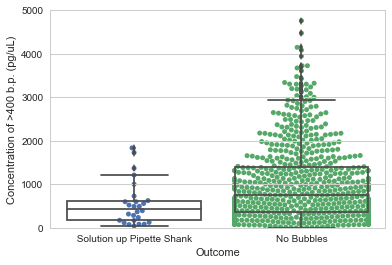

In [13]:
#sns.violinplot(x = 'Bubble_data', y = 'Picogreen', data = bubble_data)
#sns.swarmplot(x = 'Bubble_data', y = 'Picogreen', data = bubble_data)
#sns.violinplot(x = 'Bubble_data', y = '>400', data = bubble_data )
#sns.stripplot(x='Bubble_data', y='>400', data=bubble_data, jitter=True)
#sns.boxplot(x='Bubble_data', y='>400', data=bubble_data,
            #showcaps=False, boxprops={'facecolor':'None'},
            #showfliers=False,whiskerprops={'linewidth':0})
#sns.boxplot(x = 'Bubble_data', y = '>400', data = bubble_data, boxprops={'facecolor':'None'})
plt.ylim([0,5000])
#plt.xlabel('Outcome')
#plt.ylabel('Concentration of >400 b.p. (pg/uL)')
box_plot = sns.boxplot(x='Bubble_data', y='>400', data=bubble_data,
                       boxprops={'facecolor':'None'})
swarm_plot = sns.swarmplot(x='Bubble_data', y='>400', data=bubble_data, zorder=0.5)
swarm_plot.set(xlabel='Outcome', ylabel='Concentration of >400 b.p. (pg/uL)')
plt.savefig('Bubble_plot2', dpi=300)

In [242]:
ps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1681 entries, 5005 to 7538
Data columns (total 11 columns):
Date           1681 non-null datetime64[ns]
User           1681 non-null category
File           1681 non-null object
Post patch?    1675 non-null category
Notes          1681 non-null object
Picogreen      1679 non-null float64
Conc.          1676 non-null float64
>400           1651 non-null float64
Ratio          1678 non-null object
SM_QC_PF       1679 non-null category
Bad dates      0 non-null object
dtypes: category(3), datetime64[ns](1), float64(3), object(4)
memory usage: 123.3+ KB


# Percentage of nucleated patches passing SM_QC 

In [6]:
mask = ps["Post patch?"] == "Nucleated"
mask
nuc = ps[mask]
nuc.head()
nuc_count = nuc["Post patch?"].count()
nuc_count

1055

In [7]:
ps["Post patch?"].value_counts()

Nucleated             1055
No-Seal                969
Outside-Out            907
Partial-Nucleus        411
nr                     178
Entire-Cell             38
nucleus_present         32
nucleus_absent          14
no-seal                  5
no_nucleus_visible       4
nucleus_visible          3
Outside-Out?             1
outside-out              1
entire_cell              1
missing                  1
nucelated                1
no -seal                 1
Name: Post patch?, dtype: int64

In [8]:
pas = ps["SM_QC_PF"] == "pass"
pas.head()

251    False
252    False
253    False
254     True
255    False
Name: SM_QC_PF, dtype: bool

In [9]:
np = ps[mask & pas]
np

,Date,User,File,Post patch?,Notes,Conc.,>400,Ratio,SM_QC_PF,Bad dates
268,2016-04-06,P5,Ndnf - brl_160406_04,Nucleated,NaN,209.76,167.0,0.69,pass,NaN
280,2016-04-07,P1,Ndnf - kjh_160407_03,Nucleated,"cell swelled, no fluorescence visible in pipette",114.09,96.0,0.73,pass,NaN
303,2016-04-11,P5,Rorb - brl_160411_02,Nucleated,NaN,125.35,92.0,0.63,pass,NaN
320,2016-04-12,P5,Rorb - brl_160412_01,Nucleated,"couldnt see flourescence - cell too deep, but ...",195.16,183.0,0.87,pass,no slide in LIMS
360,2016-04-18,P5,Chat - brl_160418_02,Nucleated,"coudlnt get gigaseal, put still saw flur in pi...",135.75,116.0,0.85,pass,NaN
363,2016-04-18,P5,Chat - brl_160418_05,Nucleated,lost seal at 3 mins but still able to pull ou...,158.45,113.0,0.62,pass,NaN
376,2016-04-19,P1,Chat - kjh_160419_03,Nucleated,saw fluorescence in pipette,423.02,203.0,0.48,pass,NaN
395,2016-04-20,P1,Vip - kjh_160420_10,Nucleated,"saw fluorescence in pipette, cell dimmed",470.63,338.0,0.64,pass,NaN
439,2016-04-26,P5,Nos1 - brl_160426_02,Nucleated,NaN,353.39,282.0,0.73,pass,cell is between 01 and 02 (different than cell...
441,2016-04-26,P5,Nos1 - brl_160426_04,Nucleated,NaN,425.15,332.0,0.72,pass,NaN


In [10]:
nuc_pass = np["Post patch?"].count()
nuc_pass
#np["Post patch?"].count()

896

In [11]:
float(nuc_pass)/nuc_count

0.8492890995260663

# Bubbles Analysis 

In [6]:
bubbles = ps.dropna(subset = ["Notes"])
bubbles

,Date,User,File,Post patch?,Notes,Picogreen,Conc.,>400,Ratio,SM_QC_PF,Bad dates
5005,2017-04-20,P2,Vip-IRES-Cre;Ai14-313534.04.01.02,No-Seal,approached angle same as tissue angle,1012.0,978.8,558.000,0.57,pass,NaN
5006,2017-04-20,P2,Vip-IRES-Cre;Ai14-313534.04.01.03,No-Seal,approach angle same as slice angle,940.0,1166.6,506.000,0.43,pass,NaN
5008,2017-04-20,P2,Vip-IRES-Cre;Ai14-313534.04.01.05,Outside-Out,lost seal on cell during extraction,1671.0,2624.2,1770.000,0.67,pass,NaN
5018,2017-04-21,P1,Gad2-IRES-Cre;Ai14-313294.03.01.03,No-Seal,Cell Dimmed,517.0,538.4,309.000,0.57,fail,NaN
5019,2017-04-21,P1,Gad2-IRES-Cre;Ai14-313294.03.01.04,No-Seal,Fluorescence in Pipette,1425.0,2274.5,1264.000,0.56,pass,NaN
5020,2017-04-21,P1,Gad2-IRES-Cre;Ai14-313294.04.01.01,No-Seal,"Fluorescence in Pipette,Cell Dimmed 1.0",386.0,583.2,425.000,0.73,pass,NaN
5021,2017-04-21,P1,Gad2-IRES-Cre;Ai14-313294.04.01.02,Partial-Nucleus,"Fluorescence in Pipette,Cell Dimmed",842.0,1157.7,933.000,0.81,pass,NaN
5022,2017-04-21,P1,Gad2-IRES-Cre;Ai14-313294.04.01.03,Nucleated,"Fluorescence in Pipette,Cell Dimmed",1211.0,1403.9,1136.000,0.81,pass,NaN
5023,2017-04-21,P1,Gad2-IRES-Cre;Ai14-313294.04.01.04,No-Seal,Fluorescence in Pipette,683.0,1120.8,649.000,0.58,pass,NaN
5026,2017-04-21,P2,Gad2-IRES-Cre;Ai14-313294.03.02.01,Nucleated,Fluorescence in Pipette,1272.0,1827.1,1111.000,0.61,pass,NaN


In [7]:
def make_mask(v,x):
    mask = v["Notes"].str.contains(x)
    df = v[mask]
    return df

def pass_only(y):
    mask = y["SM_QC_PF"] == "pass"
    df2 = y[mask]
    return df2

#Should also define a function to calculate pass percentages

In [8]:
def get_count(x):    
    count = x[">400"].count()
    return count

def get_sqrtct(x):
    sqrt_ct = math.sqrt(get_count(x))
    return sqrt_ct

def calc_mean(x):
    mean = x[">400"].mean()
    return mean

def calc_std(x):
    std_dev = x[">400"].std()
    return std_dev

def calc_stderr(x):
    std_err = calc_std(x) / get_sqrtct(x)
    return std_err

def calc_pp(passing,total):
    pp = float(get_count(passing)) / get_count(total)
    return pp

# No Bubbles Stats - All Samples

In [9]:
nb = make_mask(bubbles,"No Bubbles")

nb_mean = calc_mean(nb)
print "mean", nb_mean

nb_stderr = calc_stderr(nb)
print "standard error of the mean", nb_stderr

mean 1046.20201765
standard error of the mean 36.3364800915


# No Bubbles Stats - SMQC Pass Only 

In [10]:
nb_p = pass_only(make_mask(bubbles,"No Bubbles"))

nb_mean = calc_mean(nb_p)
print "mean =", nb_mean

nb_stderr = calc_stderr(nb_p)
print "standard error of the mean =", nb_stderr

nb_pp = calc_pp(nb_p,nb)
print "pass percentage =", nb_pp

mean = 1249.4679291
standard error of the mean = 40.8134089764
pass percentage = 0.788235294118


# Small Bubbles Stats - All Samples 

In [11]:
sb = make_mask(bubbles,"Small Bubbles")

sb_mean = calc_mean(sb)
print "mean", sb_mean

sb_stderr = calc_stderr(sb)
print "standard error of the mean", sb_stderr

mean 1278.61701845
standard error of the mean 80.2350178526


# Small Bubbles Stats - SMQC Pass Only 

In [12]:
sb_p = pass_only(make_mask(bubbles,"Small Bubbles"))

sb_mean = calc_mean(sb_p)
print "mean", sb_mean

sb_stderr = calc_stderr(sb_p)
print "standard error of the mean", sb_stderr

sb_pp = calc_pp(sb_p,sb)
print "pass percentage =", sb_pp

mean 1567.6974988
standard error of the mean 100.254650162
pass percentage = 0.765682656827


# Medium bubbles Stats - All Samples 

In [13]:
mb = make_mask(bubbles,"Medium Bubbles")

mb_mean = calc_mean(mb)
print "mean =", mb_mean

mb_stderr = calc_stderr(mb)
print "standard error of the mean =", mb_stderr

mean = 1183.88883065
standard error of the mean = 93.5289636166


# Medium Bubbles Stats - SMQC Pass Only

In [14]:
mb_p = pass_only(make_mask(bubbles, "Medium Bubbles"))

mb_mean = calc_mean(mb_p)
print "mean =", mb_mean

mb_stderr = calc_stderr(mb_p)
print "standard error of the mean =", calc_stderr(mb_p)

mb_pp = calc_pp(mb_p,mb)
print "pass percentage =", mb_pp

print get_count(mb)
print get_count(mb_p)

mean = 1446.78187629
standard error of the mean = 104.725904686
pass percentage = 0.782258064516
124
97


# Large Bubbles Stats - All Samples 

In [15]:
lb = make_mask(bubbles,"Large Bubbles")

lb_mean = calc_mean(lb)
print "mean =", lb_mean

lb_stderr = calc_stderr(lb)
print "standard error of the mean", lb_stderr

mean = 1230.96722727
standard error of the mean 169.417703989


# Large Bubbles Stats - SMQC Pass Only 

In [16]:
lb_p = pass_only(make_mask(bubbles,"Large Bubbles"))

lb_mean = calc_mean(lb_p)
print "mean =", lb_mean

lb_stderr = calc_stderr(lb_p)
print "standard error of the mean =", lb_stderr

lb_pp = calc_pp(lb_p,lb)
print "pass percentage =", lb_pp

mean = 1497.01454286
standard error of the mean = 187.727964017
pass percentage = 0.795454545455


# Solution up Pipette - All Samples 

In [17]:
sp = make_mask(bubbles,"Solution in Pipette Shank")

sp_mean = calc_mean(sp)
print "mean =", sp_mean

sp_stderr = calc_stderr(sp)
print "standard error of the mean =", sp_stderr

mean = 739.591481481
standard error of the mean = 214.024197354


# Solution up Pipette - SMQC Pass Only 

In [18]:
sp_p = pass_only(make_mask(bubbles, "Solution in Pipette Shank"))

sp_mean = calc_mean(sp_p)
print "mean =", sp_mean

sp_stderr = calc_stderr(sp_p)
print "standard error of the mean =", sp_stderr

sp_pp = calc_pp(sp_p,sp)
print "pass percentage =", sp_pp

print get_count(sp)
print get_count(sp_p)

mean = 1118.8475625
standard error of the mean = 330.631770614
pass percentage = 0.592592592593
27
16


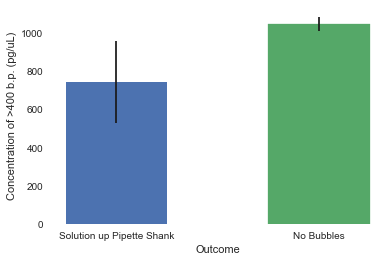

In [19]:
sns.set(style='white', color_codes = True)
outcomes = ['Solution up Pipette Shank', 'No Bubbles']
pos = np.arange(len(outcomes))

mean = [739.59, 1046.2]
sem = [214.02, 36.34]
width = 0.5
fig, ax = plt.subplots()
plot = plt.bar(pos, mean, width, yerr=sem)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plot[1].set_color('g')
plt.xticks(pos, outcomes)
plt.ylabel('Concentration of >400 b.p. (pg/uL)')
plt.xlabel('Outcome')
plt.savefig('no_bubbles', dpi=300)
#width = 0.5

#fig, ax = plt.subplots()
#rect1 = ax.bar()

#up_mean = [739.59]
#up_sem = [214.02]


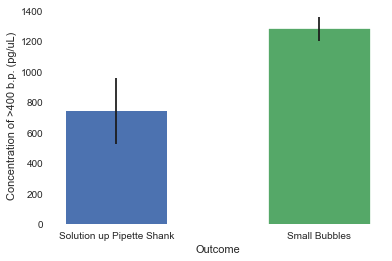

In [20]:
outcomes = ['Solution up Pipette Shank', 'Small Bubbles']
pos = np.arange(len(outcomes))

mean = [739.59, 1278.62]
sem = [214.02, 80.24]
width = 0.5
fig, ax = plt.subplots()
plot = plt.bar(pos, mean, width, yerr=sem)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plot[1].set_color('g')
plt.xticks(pos, outcomes)
plt.ylabel('Concentration of >400 b.p. (pg/uL)')
plt.xlabel('Outcome')
plt.savefig('small_bubbles', dpi=300)

In [ ]:
df = 